## Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [4]:
#imports
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
accuracy_score, roc_curve,  RocCurveDisplay, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
df = pd.read_csv('chronic_kidney_disease_full.csv')

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

In [7]:
# Answer here: #I would use all the columns to check for "class" which is:  CKD or not CKD. 
#CKD is chronic kidney disease, not CKD no chronic kidney disease. 

""" The attributes in this KFT dataset age, blood pressure, specific gravity, albumin, sugar, red blood cells, pus cell, pus cell clumps, bacteria, 
blood glucose random, blood urea, serum creatinine, 
sodium, potassium, haemoglobin, packed cell volume, white blood cell count, red blood cell count, 
hypertension, diabetes mellitus, coronary artery disease, appetite, pedal edema, anaemia, class. """ 

df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [9]:
# Answer here:
df.isnull().sum() #all columns except 'class' have nulls

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [10]:
df.shape

(400, 25)

In [11]:
df['rbc'].unique() #152/400 is a lot of data lost (if dropped)

array([nan, 'normal', 'abnormal'], dtype=object)

In [12]:
df['rbcc'].unique() #131/400 is a lot of data lost (if dropped)

array([5.2, nan, 3.9, 4.6, 4.4, 5. , 4. , 3.7, 3.8, 3.4, 2.6, 2.8, 4.3,
       3.2, 3.6, 4.1, 4.9, 2.5, 4.2, 4.5, 3.1, 4.7, 3.5, 6. , 2.1, 5.6,
       2.3, 2.9, 2.7, 8. , 3.3, 3. , 2.4, 4.8, 5.4, 6.1, 6.2, 6.3, 5.1,
       5.8, 5.5, 5.3, 6.4, 5.7, 5.9, 6.5])

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

In [14]:
# Answer here:

#If ALL the rows are dropped due to missing values, the data lost would be large, and equals 60.5%. The total remaining rows would be: 
total_nans = df.isna().any(axis=1).sum()
total_nans
percent_data_loss = (total_nans/len(df))*100
percent_data_loss
print(f'The remaining rows are {total_nans} and the percentage of data lost is {percent_data_loss}%.')

The remaining rows are 242 and the percentage of data lost is 60.5%.


In [15]:
# Downsides to doing this:
#1. Large percent of data lost, which reduces the model's ability to capture actual patterns in the data, lowering performance or accuracy.
#2. introducing class imbalance and representation in the model, thus maybe introducing bias.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

In [17]:
# Answer here:

#1. contaminated samples: the sample was compromised by other substances so that the count was invalid.

#2. insufficient sample, e.g. there was not enough blood for the samples to be drawn from the patient due to limitations such as old age to do all 22 tests.

#3. incomplete testing. e.g. the patient changed hospitals for treatment and left the experiment.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

In [19]:
# Answer here:
#false negatives are 0. people with the disease, will be all falsely told they are in the positive class (CKD=1)


### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

In [21]:
# Answer here: CKD= 1, no-CKD = 0 

# We are minimizing for false negatives (telling patients they do not have CKD but they have). 
# Thus, recall.


### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

In [23]:
# Answer here:
# People with CKD will not know they have the disease so they will not change any habits to extend their life
# or get proper, timely treatment.


### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

In [25]:
# Answer here:  CKD= 1, no-CKD = 0 
#I will create a false positive where I tell the patient they have CKD but they don't.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

In [27]:
# Answer here: false positives, metric is precision

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

In [29]:
# Answer here: 
#the person will stress over the disease unnecessarily. 

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [31]:
df.isnull().sum().sort_values(ascending=False)

rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [32]:
"""['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class']"""

"['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',\n       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',\n       'appet', 'pe', 'ane', 'class']"

In [33]:
# I decided to impute the median for each NaN since I would loose too many rows of data. 

In [34]:
df['al'].isnull().sum()

46

In [35]:
df['al'].mean()

1.0169491525423728

In [36]:
df['al'].fillna(df['al'].mean(), inplace=True)

In [37]:
df['al'].unique()

array([1.        , 4.        , 2.        , 3.        , 0.        ,
       1.01694915, 5.        ])

In [38]:
df['sc'].isnull().sum()

17

In [39]:
df['sc'].unique()

array([ 1.2 ,  0.8 ,  1.8 ,  3.8 ,  1.4 ,  1.1 , 24.  ,  1.9 ,  7.2 ,
        4.  ,  2.7 ,  2.1 ,  4.6 ,  4.1 ,  9.6 ,  2.2 ,  5.2 ,  1.3 ,
        1.6 ,  3.9 , 76.  ,  7.7 ,   nan,  2.4 ,  7.3 ,  1.5 ,  2.5 ,
        2.  ,  3.4 ,  0.7 ,  1.  , 10.8 ,  6.3 ,  5.9 ,  0.9 ,  3.  ,
        3.25,  9.7 ,  6.4 ,  3.2 , 32.  ,  0.6 ,  6.1 ,  3.3 ,  6.7 ,
        8.5 ,  2.8 , 15.  ,  2.9 ,  1.7 ,  3.6 ,  5.6 ,  6.5 ,  4.4 ,
       10.2 , 11.5 ,  0.5 , 12.2 ,  5.3 ,  9.2 , 13.8 , 16.9 ,  6.  ,
        7.1 , 18.  ,  2.3 , 13.  , 48.1 , 14.2 , 16.4 ,  2.6 ,  7.5 ,
        4.3 , 18.1 , 11.8 ,  9.3 ,  6.8 , 13.5 , 12.8 , 11.9 , 12.  ,
       13.4 , 15.2 , 13.3 ,  0.4 ])

In [40]:
df['bu'].fillna(df['bu'].mean(), inplace=True)

In [41]:
df['bu'].isnull().sum()

0

In [42]:
df['sc'].fillna(df['sc'].mean(), inplace=True)

In [43]:
df['bu'].unique()

array([ 36.        ,  18.        ,  53.        ,  56.        ,
        26.        ,  25.        ,  54.        ,  31.        ,
        60.        , 107.        ,  55.        ,  72.        ,
        86.        ,  90.        , 162.        ,  46.        ,
        87.        ,  27.        , 148.        , 180.        ,
       163.        ,  57.42572178,  50.        ,  75.        ,
        45.        ,  28.        , 155.        ,  33.        ,
        39.        , 153.        ,  29.        ,  65.        ,
       103.        ,  70.        ,  80.        ,  20.        ,
       202.        ,  77.        ,  89.        ,  24.        ,
        17.        ,  32.        , 114.        ,  66.        ,
        38.        , 164.        , 142.        ,  96.        ,
       391.        ,  15.        , 111.        ,  73.        ,
        19.        ,  92.        ,  35.        ,  16.        ,
       139.        ,  48.        ,  85.        ,  98.        ,
       186.        ,  37.        ,  47.        ,  52.  

In [44]:
df[['al', 'sc', 'bu']]

,al,sc,bu
0,1.0,1.2,36.0
1,4.0,0.8,18.0
2,2.0,1.8,53.0
3,4.0,3.8,56.0
4,2.0,1.4,26.0
...,...,...,...
395,0.0,0.5,49.0
396,0.0,1.2,31.0
397,0.0,0.6,26.0
398,0.0,1.0,50.0


In [45]:
#for the dummy variables, I will also impute nans to no

In [46]:
df['dm'].unique()

array(['yes', 'no', nan], dtype=object)

In [47]:
df['htn'].unique()

array(['yes', 'no', nan], dtype=object)

In [48]:
df['cad'].unique()

array(['no', 'yes', nan], dtype=object)

In [49]:
df['dm'].isnull().sum()

2

In [50]:
df['htn'].isnull().sum()

2

In [51]:
df['cad'].isnull().sum()

2

In [52]:
df['dm'].fillna('no', inplace=True)

In [53]:
df['htn'].fillna('no', inplace=True)

In [54]:
df['cad'].fillna('no', inplace=True)

In [55]:
df['dm'].isnull().sum()

0

In [56]:
df['htn'].isnull().sum()

0

In [57]:
df['cad'].isnull().sum()

0

In [58]:
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


In [59]:
#make ckd = 1/not cdk = 0 in the class column
df['class'] = df['class'].map({'ckd' : 1, 'notckd' : 0})

In [60]:
df['class']

0      1
1      1
2      1
3      1
4      1
      ..
395    0
396    0
397    0
398    0
399    0
Name: class, Length: 400, dtype: int64

In [61]:
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,1
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,1
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,1
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47.0,6700.0,4.9,no,no,no,good,no,no,0
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54.0,7800.0,6.2,no,no,no,good,no,no,0
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49.0,6600.0,5.4,no,no,no,good,no,no,0
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51.0,7200.0,5.9,no,no,no,good,no,no,0


In [62]:
# get dummies for the dataframe, convert dtype of the dummies to integers instead of the default bool

df = pd.get_dummies(df, dtype=int)
df

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,dm_no,dm_yes,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0,1,1,0,1,0,1,0,1,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,1,0,1,0,1,0,1,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,0,1,1,0,0,1,1,0,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,1,0,1,0,0,1,0,1,0,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,140.0,49.0,0.5,150.0,4.9,...,1,0,1,0,1,0,1,0,1,0
396,42.0,70.0,1.025,0.0,0.0,75.0,31.0,1.2,141.0,3.5,...,1,0,1,0,1,0,1,0,1,0
397,12.0,80.0,1.020,0.0,0.0,100.0,26.0,0.6,137.0,4.4,...,1,0,1,0,1,0,1,0,1,0
398,17.0,60.0,1.025,0.0,0.0,114.0,50.0,1.0,135.0,4.9,...,1,0,1,0,1,0,1,0,1,0


In [63]:
# calculate correlation of the X features against target value y = 'class' (maximum correlation = 1) column

corr_features = df.corr()['class'].sort_values(key=lambda x: x.abs(), ascending=False)
corr_features # 'pot' has the lowest correlation

class             1.000000
hemo             -0.768919
pcv              -0.741427
sg               -0.732163
rbcc             -0.699089
rbc_normal       -0.677781
al                0.599238
htn_no           -0.590438
htn_yes           0.590438
dm_no            -0.559060
dm_yes            0.559060
pc_normal        -0.474244
bgr               0.419672
appet_poor        0.393341
appet_good       -0.383621
sod              -0.375674
pc_abnormal       0.375154
pe_yes            0.375154
bu                0.372033
pe_no            -0.365101
su                0.344070
ane_yes           0.325396
ane_no           -0.314216
sc                0.294079
bp                0.294077
rbc_abnormal      0.282642
pcc_present       0.265313
cad_no           -0.236088
cad_yes           0.236088
wbcc              0.231919
age               0.227268
pcc_notpresent   -0.214476
ba_present        0.186871
ba_notpresent    -0.120445
pot               0.084541
Name: class, dtype: float64

In [64]:
df.isnull().sum().sort_values(ascending=False) 

rbcc              131
wbcc              106
pot                88
sod                87
pcv                71
hemo               52
su                 49
sg                 47
bgr                44
bp                 12
age                 9
htn_no              0
pe_no               0
pe_yes              0
appet_poor          0
appet_good          0
cad_yes             0
ane_no              0
cad_no              0
dm_yes              0
dm_no               0
htn_yes             0
pc_abnormal         0
ba_present          0
ba_notpresent       0
pcc_present         0
pcc_notpresent      0
pc_normal           0
rbc_normal          0
rbc_abnormal        0
class               0
sc                  0
bu                  0
al                  0
ane_yes             0
dtype: int64

In [65]:
# impute the rest of the NaNs of each numerical column,
numerical_cols = 'rbcc', 'wbcc', 'pot', 'sod', 'pcv', 'hemo', 'su', 'sg', 'bgr', 'bp', 'age'

for column in numerical_cols:
    df[column] = df[column].fillna(df[column].mean())

In [66]:
df

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,dm_no,dm_yes,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,137.528754,4.627244,...,0,1,1,0,1,0,1,0,1,0
1,7.0,50.0,1.020,4.0,0.0,148.036517,18.0,0.8,137.528754,4.627244,...,1,0,1,0,1,0,1,0,1,0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,137.528754,4.627244,...,0,1,1,0,0,1,1,0,0,1
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,...,1,0,1,0,0,1,0,1,0,1
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,137.528754,4.627244,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,140.000000,49.0,0.5,150.000000,4.900000,...,1,0,1,0,1,0,1,0,1,0
396,42.0,70.0,1.025,0.0,0.0,75.000000,31.0,1.2,141.000000,3.500000,...,1,0,1,0,1,0,1,0,1,0
397,12.0,80.0,1.020,0.0,0.0,100.000000,26.0,0.6,137.000000,4.400000,...,1,0,1,0,1,0,1,0,1,0
398,17.0,60.0,1.025,0.0,0.0,114.000000,50.0,1.0,135.000000,4.900000,...,1,0,1,0,1,0,1,0,1,0


In [67]:
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'class', 'rbc_abnormal', 'rbc_normal',
       'pc_abnormal', 'pc_normal', 'pcc_notpresent', 'pcc_present',
       'ba_notpresent', 'ba_present', 'htn_no', 'htn_yes', 'dm_no', 'dm_yes',
       'cad_no', 'cad_yes', 'appet_good', 'appet_poor', 'pe_no', 'pe_yes',
       'ane_no', 'ane_yes'],
      dtype='object')

## Decisions for dropping columns

In [69]:
# I will drop the columns that have the following keywords:

# "no" e.g. 'cad_no' and 'cad_yes' 
# "poor" e.g. 'appet_poor' and 'appet_good' 
# "normal" (vs. keeping 'abnormal')
# 'present' (vs. 'not present')
# "rbcc" can be dropped because it is used to calculate the rbc_normal/rbc_abnormal

# Although we are not sure if these choices are medically significant (present/not present or good or poor, etc.), 
# we can still retain the information of the data if we dropped only one of the pair as it is redundant to have both.

In [70]:
# Drop 'pot' due to low correlation

In [71]:
# drop the columns with too many NaNs(>80 NaNs out of 400) = 'wbcc', 'sod', 'bgr'

In [72]:
#total cols to drop are: 'rbcc', 'wbcc', 'sod', 'bgr', 'pot', 'rbc_normal', 'pc_normal', 'dm_no', 'cad_no', 'appet_poor', 
# 'pe_no', 'ane_no', 'pcc_notpresent', 'ba_not_present', 'htn_no'
df = df.drop(columns=['rbcc', 'wbcc', 'sod', 'bgr', 'pot', 'rbc_normal', 'pc_normal', 'dm_no', 'cad_no', 'appet_poor', 
'pe_no', 'ane_no', 'pcc_notpresent', 'ba_notpresent', 'htn_no'])

In [73]:
df.shape

(400, 20)

In [74]:
df.columns #19 columns left

Index(['age', 'bp', 'sg', 'al', 'su', 'bu', 'sc', 'hemo', 'pcv', 'class',
       'rbc_abnormal', 'pc_abnormal', 'pcc_present', 'ba_present', 'htn_yes',
       'dm_yes', 'cad_yes', 'appet_good', 'pe_yes', 'ane_yes'],
      dtype='object')

In [75]:
df.dtypes

age             float64
bp              float64
sg              float64
al              float64
su              float64
bu              float64
sc              float64
hemo            float64
pcv             float64
class             int64
rbc_abnormal      int32
pc_abnormal       int32
pcc_present       int32
ba_present        int32
htn_yes           int32
dm_yes            int32
cad_yes           int32
appet_good        int32
pe_yes            int32
ane_yes           int32
dtype: object

In [76]:
df.isnull().sum()

age             0
bp              0
sg              0
al              0
su              0
bu              0
sc              0
hemo            0
pcv             0
class           0
rbc_abnormal    0
pc_abnormal     0
pcc_present     0
ba_present      0
htn_yes         0
dm_yes          0
cad_yes         0
appet_good      0
pe_yes          0
ane_yes         0
dtype: int64

## Create X feature matrix , y target series

In [78]:
# Create feature matrix X.

In [79]:
X = df.drop(columns=['class'])

In [80]:
X.head()

,age,bp,sg,al,su,bu,sc,hemo,pcv,rbc_abnormal,pc_abnormal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_good,pe_yes,ane_yes
0,48.0,80.0,1.020,1.0,0.0,36.0,1.2,15.4,44.0,0,0,0,0,1,1,0,1,0,0
1,7.0,50.0,1.020,4.0,0.0,18.0,0.8,11.3,38.0,0,0,0,0,0,0,0,1,0,0
2,62.0,80.0,1.010,2.0,3.0,53.0,1.8,9.6,31.0,0,0,0,0,0,1,0,0,0,1
3,48.0,70.0,1.005,4.0,0.0,56.0,3.8,11.2,32.0,0,1,1,0,1,0,0,0,1,1
4,51.0,80.0,1.010,2.0,0.0,26.0,1.4,11.6,35.0,0,0,0,0,0,0,0,1,0,0


In [81]:
X.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bu', 'sc', 'hemo', 'pcv',
       'rbc_abnormal', 'pc_abnormal', 'pcc_present', 'ba_present', 'htn_yes',
       'dm_yes', 'cad_yes', 'appet_good', 'pe_yes', 'ane_yes'],
      dtype='object')

In [82]:
#baseline is 62% CKD or NOT-CKD in the 'class' column
y = df['class'] 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42) 
# I chose 0.20 for the test size instead of 0.25 as I wanted the model to capture more of the train pattern.

In [84]:
# Scale Features
sc = StandardScaler() # scaled data to get rid of bias from the different units

# Fit/transform
X_train_sc = sc.fit_transform(X_train)

# Transform
X_test_sc = sc.transform(X_test)

In [85]:
lr = LogisticRegression()
lr.fit(X_train_sc, y_train)

LogisticRegression()

In [86]:
lr.score(X_train_sc, y_train)

0.996875

In [87]:
lr.score(X_test_sc, y_test)

0.975

In [88]:
ypreds = lr.predict(X_test_sc)

In [89]:
ypreds

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0], dtype=int64)

In [90]:
accuracy_score(y_test, ypreds)

0.975

In [91]:
y_test

342    0
204    1
233    1
366    0
120    1
      ..
128    1
353    0
44     1
171    1
298    0
Name: class, Length: 80, dtype: int64

In [92]:
cm = confusion_matrix(y_test, ypreds)

In [93]:
lr.classes_

array([0, 1], dtype=int64)

In [94]:
cm

array([[30,  0],
       [ 2, 48]], dtype=int64)

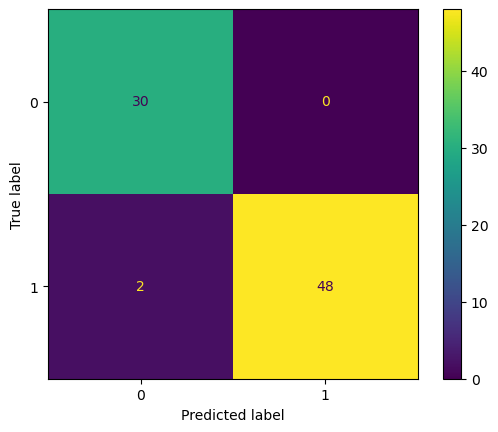

In [95]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_).plot();

In [96]:
print(classification_report(y_test, ypreds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       1.00      0.96      0.98        50

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [98]:
X_train.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bu', 'sc', 'hemo', 'pcv',
       'rbc_abnormal', 'pc_abnormal', 'pcc_present', 'ba_present', 'htn_yes',
       'dm_yes', 'cad_yes', 'appet_good', 'pe_yes', 'ane_yes'],
      dtype='object')

In [99]:
coeff_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr.coef_[0]})
coeff_df

,Feature,Coefficient
0,age,-0.121924
1,bp,0.574036
2,sg,-1.733203
3,al,1.037413
4,su,0.758170
5,bu,0.174256
6,sc,0.909663
7,hemo,-1.698729
8,pcv,-1.695355
9,rbc_abnormal,0.560933


In [100]:
# For example, as feature albumin 'al' increases by one unit, the log odds of someone having CKD incerases by approximately 1. (coeff_ is 1.03)

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [102]:
# as dm_yes increases by one unit, the log odds of someone having CKD incerases by 1. 

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: The advantages of using logistic regression as a modeling technique are 
Logistic regression is a classification algorithm that shares similar properties to linear regression.
The coefficients in a logistic regression model are interpretable. (They represent the change in log-odds caused by the input variables.)
Logistic regression is a very fast model to fit and generate predictions from.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why?

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [106]:
# Yes, confusion matrices are useful to see our false positives and negatives, thus helping in visualizing the model's performance. 
tp, fn, fp, tn = 2, 48 , 30, 0
# Confusion Matrix
confusion_matrix(y_test, ypreds)

array([[30,  0],
       [ 2, 48]], dtype=int64)

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: We would want to minimize predicting no CKD (0) but they had CKD (1), which is a False Negative. For CKD, early detection is critical to the patient managing the disease, so a higher sensitivity (the portion of true positives) might be preferred.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

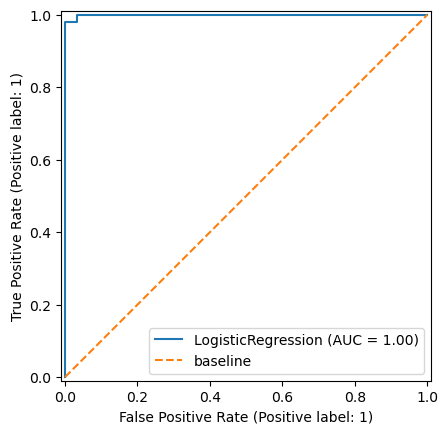

In [110]:
RocCurveDisplay.from_estimator(lr, X_test_sc, y_test)
plt.plot([0,1], [0,1], label='baseline', linestyle= '--')
plt.legend();

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: An unbalanced class is an uneven distribution or skew of the class. Imbalanced class distribution poses a challenge for class prediction.
Slight imbalances are ok such as in this particular CKD case (250 people for non-CKD vs. 150 people for CKD), techniques can be used to minimize the imbalances such as:

1. Weighting observations. 2. Stratified cross-validation.  some of our folds have no observations from the minority class. Stratifying is almost always a good ide3
3. 
Chge anthe threshold for classificatio
4. k.
Create synthetic data of minoritl6. 
5. ss.
Oversample minor c7. 
6. ass.
Undersample majty 8. 
7. lass.
Combine oversampling majority and undersampling micty c9. l8. asses.
Optimize for a specifi e.g. sensitivity metric.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: The majority class are the healthy people who do not have CKD. 
As the model is fed more data from this majority class than the minority, the model will predict the majority class more accurately from the training data than predicting for the minority (people who have the disease), since there is a lower portion of people with the disease in the dataset to train on. Hence it may predict patients incorrectly e.g. healthy patients will be told they have CKD causing them to be upset unnecesarily, and the model may predict CKD patients as healthy, preventing timely treatment.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [116]:
#define major/ minor class
major = df[df['class'] == 1]  # CKD
minor = df[df['class'] == 0]  

# random sample of size 200,000 of people with CKD, with replacement
bootstrap_major = np.random.choice(major.index, size=200000, replace=True)

# new dataframe with the original data plus this random sample of data.
boots_df = major.loc[bootstrap_major]
n_df = pd.concat([df, boots_df], ignore_index=True)
print(n_df['class'].value_counts())

class
1    200250
0       150
Name: count, dtype: int64


### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [118]:
X_unbal= n_df.drop(columns=['class'])
y_unbal = n_df['class']

In [119]:
X_ub_train, X_ub_test, y_ub_train, y_ub_test = train_test_split(X_unbal, y_unbal, random_state=42)

In [209]:
# sc = StandardScaler()

# # Fit/transform
# X_ub_train_sc = sc.fit_transform(X_ub_train)

# # Transform
# X_ub_test_sc = sc.transform(X_ub_test)

In [215]:
unbal_lr = LogisticRegression(max_iter=1000)
unbal_lr.fit(X_ub_train, y_ub_train)

LogisticRegression(max_iter=1000)

In [217]:
y_un_pred=unbal_lr.predict(X_ub_test)

In [219]:
unbal_lr.score(X_ub_train, y_ub_train)

0.9997139055222888

In [221]:
unbal_lr.score(X_ub_test, y_ub_test)

0.9995808383233533

In [223]:
print("Classification Report:", classification_report(y_ub_test, y_un_pred))

Classification Report:               precision    recall  f1-score   support

           0       1.00      0.57      0.73        49
           1       1.00      1.00      1.00     50051

    accuracy                           1.00     50100
   macro avg       1.00      0.79      0.86     50100
weighted avg       1.00      1.00      1.00     50100



In [ ]:
# The impact of the unbalanced classes improved the accuracy of the model dramatically to 99%, 
# which is a critical percentage for medical cases such as disease prediction to be highly accurate as the cost of the errors are high in terms of human life.

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

In [ ]:
# Problem statement: Does the patient have CKD or not? 
# Answer: We present a model, with 19 features as input, that predicts the patient's category (CKD or not CKD) with minimum false postitives and false negatives.
# An improvement of the model where we trained the model with more minority classes, dramatically reduced these errors to have an accuracy of 99% 
# so CKD patients identified can get treatment in time and healthy patients are given peace of mind.
# Nonetheless, these errors may still exist despite further model techniques to improve the model,
# additional diagnostic tests can be prescribed per usual to double check any doubts. 